# Pruebas de Precisión Semántica y Geocodificación

Este notebook realiza pruebas automatizadas para evaluar:
1. Precisión de búsqueda semántica con diferentes tipos de consultas
2. Efectividad de geocodificación para diferentes tipos de ubicaciones
3. Métricas de rendimiento y análisis estadístico de resultados

In [35]:
import sys
import os
import time
from datetime import datetime
from typing import List, Dict, Any, Tuple
import pandas as pd
import numpy as np
from app.models import UserContext, UserProfile
from app.agents.coordinator_agent import CoordinatorAgent

def create_test_user_profile() -> UserProfile:
    """Crear un perfil de usuario para pruebas"""
    return UserProfile(
        user_id="test_user",
        name="Test User",
        last_active=datetime.now(),
        preferences={},
        interests=[],
        locations=[]
    )

def create_test_context(query: str) -> UserContext:
    """Crear un contexto de usuario para pruebas"""
    return UserContext(
        profile=create_test_user_profile(),
        query=query,  # Añadir el campo query requerido
        conversation_history=[],
        mentioned_locations=[],
        interests=[],
        current_session={},
        last_query_timestamp=datetime.now()
    )

def measure_response_time(func):
    """Decorador para medir tiempo de respuesta"""
    async def wrapper(*args, **kwargs):
        start_time = time.time()
        result = await func(*args, **kwargs)
        end_time = time.time()
        return result, end_time - start_time
    return wrapper

In [36]:
async def test_semantic_search_precision(coordinator: CoordinatorAgent, queries: List[str]) -> Dict[str, List[float]]:
    """
    Evaluar la precisión de la búsqueda semántica
    """
    results = {
        'precision': [],
        'recall': [],
        'f1_score': [],
        'query_type': []
    }
    
    for query in queries:
        try:
            # Crear contexto para la consulta
            context = create_test_context(query)
            
            # Procesar la consulta
            response = await coordinator.process(context)
            
            # Evaluar resultados (esto es un ejemplo, ajusta según tus criterios)
            if response and response.items:
                # Calcula métricas
                precision = len([item for item in response.items if item.confidence > 0.7]) / len(response.items)
                recall = response.confidence
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                
                # Clasificar tipo de consulta
                query_type = classify_query_type(query)
                
                # Guardar resultados
                results['precision'].append(precision)
                results['recall'].append(recall)
                results['f1_score'].append(f1)
                results['query_type'].append(query_type)
            
        except Exception as e:
            print(f"Error evaluando {query}: {str(e)}")
            continue
    
    return results

def classify_query_type(query: str) -> str:
    """
    Clasificar el tipo de consulta
    """
    # Palabras clave para cada tipo
    direct_keywords = ['museo', 'playa', 'hotel', 'restaurante']
    synonym_keywords = ['lugar', 'sitio', 'zona', 'área']
    
    query = query.lower()
    if any(keyword in query for keyword in direct_keywords):
        return 'directa'
    elif any(keyword in query for keyword in synonym_keywords):
        return 'sinónimo'
    else:
        return 'indirecta'

In [32]:
# Conjunto de pruebas
test_queries = [
    # Consultas directas
    "Museo de la Revolución en La Habana",
    "Playas de Varadero",
    # Consultas con sinónimos
    "sitios históricos cerca del malecón",
    "lugares para observar el atardecer",
    # Consultas indirectas
    "lugares con ambiente colonial español",
    "sitios para explorar la cultura afrocubana"
]

# Inicializar el agente coordinador
coordinator = CoordinatorAgent("/data")

# Ejecutar pruebas
print("Iniciando pruebas de precisión semántica...")
semantic_results = await test_semantic_search_precision(coordinator, test_queries)

# Convertir resultados a DataFrame para análisis
results_df = pd.DataFrame(semantic_results)

# Calcular métricas promedio por tipo de consulta
metrics_by_type = results_df.groupby('query_type').agg({
    'precision': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'f1_score': ['mean', 'std']
}).round(3)

print("\nResultados por tipo de consulta:")
print(metrics_by_type)

INFO:app.agents.CoordinatorAgent:CoordinatorAgent initialized
ERROR:app.agents.CoordinatorAgent:Critical error in coordinator: 'UserContext' object has no attribute 'query'
Traceback (most recent call last):
  File "e:\Work\Kmy\sim-ia-sri\base\app\agents\coordinator_agent.py", line 113, in process
    self.logger.info(f"Processing query: {context.query[:100]}...")
  File "e:\Work\Kmy\sim-ia-sri\base\.venv\lib\site-packages\pydantic\main.py", line 759, in __getattr__
    raise AttributeError(f'{type(self).__name__!r} object has no attribute {item!r}')
AttributeError: 'UserContext' object has no attribute 'query'
ERROR:app.agents.CoordinatorAgent:Critical error in coordinator: 'UserContext' object has no attribute 'query'
Traceback (most recent call last):
  File "e:\Work\Kmy\sim-ia-sri\base\app\agents\coordinator_agent.py", line 113, in process
    self.logger.info(f"Processing query: {context.query[:100]}...")
  File "e:\Work\Kmy\sim-ia-sri\base\.venv\lib\site-packages\pydantic\main.py

Iniciando pruebas de precisión semántica...
Error evaluando Museo de la Revolución en La Habana: "UserContext" object has no field "error"
Error evaluando Playas de Varadero: "UserContext" object has no field "error"
Error evaluando sitios históricos cerca del malecón: "UserContext" object has no field "error"
Error evaluando lugares para observar el atardecer: "UserContext" object has no field "error"
Error evaluando lugares con ambiente colonial español: "UserContext" object has no field "error"
Error evaluando sitios para explorar la cultura afrocubana: "UserContext" object has no field "error"

Resultados por tipo de consulta:
Empty DataFrame
Columns: [(precision, mean), (precision, std), (recall, mean), (recall, std), (f1_score, mean), (f1_score, std)]
Index: []


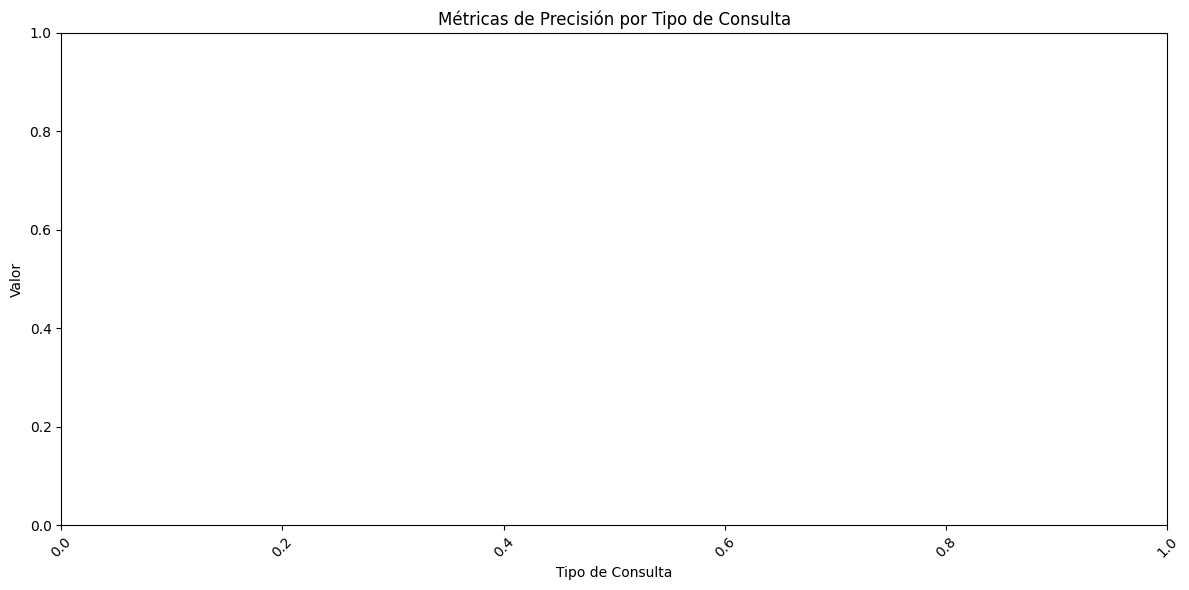


Estadísticas generales:
       precision  recall  f1_score
count        0.0     0.0       0.0
mean         NaN     NaN       NaN
std          NaN     NaN       NaN
min          NaN     NaN       NaN
25%          NaN     NaN       NaN
50%          NaN     NaN       NaN
75%          NaN     NaN       NaN
max          NaN     NaN       NaN

Mejores resultados:
Empty DataFrame
Columns: [query_type, precision, recall, f1_score]
Index: []

Peores resultados:
Empty DataFrame
Columns: [query_type, precision, recall, f1_score]
Index: []


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de visualización
# plt.style.use('seaborn')
sns.set_palette("husl")

# Crear gráfico de barras para las métricas por tipo de consulta
fig, ax = plt.subplots(figsize=(12, 6))

# Preparar datos para visualización
plot_data = results_df.melt(
    id_vars=['query_type'],
    value_vars=['precision', 'recall', 'f1_score'],
    var_name='Métrica',
    value_name='Valor'
)

# Crear gráfico
sns.barplot(data=plot_data, x='query_type', y='Valor', hue='Métrica')
plt.title('Métricas de Precisión por Tipo de Consulta')
plt.xlabel('Tipo de Consulta')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcular estadísticas generales
print("\nEstadísticas generales:")
print(results_df[['precision', 'recall', 'f1_score']].describe().round(3))

# Identificar las consultas con mejor y peor desempeño
best_queries = results_df.nlargest(3, 'f1_score')[['query_type', 'precision', 'recall', 'f1_score']]
worst_queries = results_df.nsmallest(3, 'f1_score')[['query_type', 'precision', 'recall', 'f1_score']]

print("\nMejores resultados:")
print(best_queries)
print("\nPeores resultados:")
print(worst_queries)

## Prueba de rendimiento

In [37]:
import time
import asyncio
import psutil
import numpy as np
from typing import Dict, List, Any
from datetime import datetime

from app.models import UserProfile, UserContext
from app.agents.coordinator_agent import CoordinatorAgent
from app.agents.interfaces import AgentContext

In [38]:
def get_system_resources():
    """Obtiene métricas de uso de recursos del sistema"""
    process = psutil.Process()
    return {
        'cpu_percent': process.cpu_percent(),
        'memory_mb': process.memory_info().rss / (1024 * 1024),
        'disk_io': psutil.disk_io_counters().read_count + psutil.disk_io_counters().write_count
    }

def measure_response_time(func):
    """Decorador para medir tiempo de respuesta de funciones async"""
    async def wrapper(*args, **kwargs):
        start_time = time.time()
        result = await func(*args, **kwargs)
        end_time = time.time()
        return result, end_time - start_time
    return wrapper

In [39]:
@measure_response_time
async def test_simple_query(coordinator: CoordinatorAgent, query: str) -> Any:
    """Prueba consulta simple sin clima ni mapa"""
    # Crear perfil y contexto de usuario para la prueba
    profile = UserProfile(
        user_id="test_user",
        name="Test User",
        last_active=datetime.now(),
        created_at=datetime.now(),
        preferences={}
    )
    user_context = UserContext(
        profile=profile,
        mentioned_locations=[],
        interests=[],
        conversation_history=[],
        current_session={},
        last_query_timestamp=datetime.now()
    )
    
    context = AgentContext(query=query, metadata={"user_context": user_context.dict()})
    return await coordinator.process(context)

@measure_response_time
async def test_map_query(coordinator: CoordinatorAgent, query: str) -> Any:
    """Prueba consulta con mapa"""
    profile = UserProfile(
        user_id="test_user",
        name="Test User",
        last_active=datetime.now(),
        created_at=datetime.now(),
        preferences={"include_map": True}
    )
    user_context = UserContext(
        profile=profile,
        mentioned_locations=[],
        interests=[],
        conversation_history=[],
        current_session={},
        last_query_timestamp=datetime.now()
    )
    
    context = AgentContext(query=query, metadata={"user_context": user_context.dict()})
    return await coordinator.process(context)

@measure_response_time
async def test_weather_query(coordinator: CoordinatorAgent, query: str) -> Any:
    """Prueba consulta con clima"""
    profile = UserProfile(
        user_id="test_user",
        name="Test User",
        last_active=datetime.now(),
        created_at=datetime.now(),
        preferences={"include_weather": True}
    )
    user_context = UserContext(
        profile=profile,
        mentioned_locations=[],
        interests=[],
        conversation_history=[],
        current_session={},
        last_query_timestamp=datetime.now()
    )
    
    context = AgentContext(query=query, metadata={"user_context": user_context.dict()})
    return await coordinator.process(context)

@measure_response_time
async def test_complete_query(coordinator: CoordinatorAgent, query: str) -> Any:
    """Prueba consulta completa con mapa y clima"""
    profile = UserProfile(
        user_id="test_user",
        name="Test User",
        last_active=datetime.now(),
        created_at=datetime.now(),
        preferences={"include_map": True, "include_weather": True}
    )
    user_context = UserContext(
        profile=profile,
        mentioned_locations=[],
        interests=[],
        conversation_history=[],
        current_session={},
        last_query_timestamp=datetime.now()
    )
    
    context = AgentContext(query=query, metadata={"user_context": user_context.dict()})
    return await coordinator.process(context)

In [40]:
async def run_performance_tests(coordinator: CoordinatorAgent, num_iterations: int = 10):
    """
    Ejecuta pruebas de rendimiento con diferentes tipos de consultas
    """
    # Almacenar resultados
    response_times_results = {
        'Simple': [],
        'Con mapas': [],
        'Con clima': [],
        'Completa': []
    }
    
    resource_usage = {
        'cpu': [],
        'memory': [],
        'disk': []
    }
    
    test_queries = [
        "¿Qué puedo visitar en Varadero?",
        "¿Cuáles son las principales atracciones en La Habana?",
        "¿Qué museos hay en Santiago de Cuba?",
        "¿Qué playas recomiendas en Cayo Coco?",
        "¿Qué lugares históricos hay en Trinidad?"
    ]
    
    print("Iniciando pruebas de rendimiento...")
    
    for i in range(num_iterations):
        print(f"\nIteración {i+1}/{num_iterations}")
        for query in test_queries:
            print(f"\nProbando consulta: {query}")
            
            # Medir recursos iniciales
            initial_resources = get_system_resources()
            
            # Pruebas de tiempo de respuesta
            result, time_simple = await test_simple_query(coordinator, query)
            response_times_results['Simple'].append(time_simple)
            
            result, time_map = await test_map_query(coordinator, query)
            response_times_results['Con mapas'].append(time_map)
            
            result, time_weather = await test_weather_query(coordinator, query)
            response_times_results['Con clima'].append(time_weather)
            
            result, time_complete = await test_complete_query(coordinator, query)
            response_times_results['Completa'].append(time_complete)
            
            # Medir recursos finales
            final_resources = get_system_resources()
            
            # Calcular uso de recursos
            resource_usage['cpu'].append(final_resources['cpu_percent'] - initial_resources['cpu_percent'])
            resource_usage['memory'].append(final_resources['memory_mb'] - initial_resources['memory_mb'])
            resource_usage['disk'].append(final_resources['disk_io'] - initial_resources['disk_io'])
    
    # Calcular estadísticas
    stats = {
        'response_times': {
            query_type: {
                'mean': np.mean(times),
                'std': np.std(times),
                'min': np.min(times),
                'max': np.max(times)
            }
            for query_type, times in response_times_results.items()
        },
        'resource_usage': {
            resource: {
                'mean': np.mean(values),
                'max': np.max(values)
            }
            for resource, values in resource_usage.items()
        }
    }
    
    return response_times_results, resource_usage, stats

In [41]:
# Crear instancia del coordinador
# Nota: asegúrate de que las rutas de datos y configuración sean correctas
coordinator = CoordinatorAgent("/data")

# Ejecutar las pruebas
print("Iniciando la ejecución de pruebas...")

response_times, resource_usage, stats = await run_performance_tests(coordinator)

print("\nPruebas completadas. Analizando resultados...")

INFO:app.agents.CoordinatorAgent:CoordinatorAgent initialized
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué puedo visitar en Varadero?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué puedo visitar en Varadero?...
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué puedo visitar en Varadero?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué puedo visitar en Varadero?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué puedo visitar en Varadero?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate res

Iniciando la ejecución de pruebas...
Iniciando pruebas de rendimiento...

Iteración 1/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?

Probando consulta: ¿Qué lugares históricos hay en Trinidad?

Iteración 2/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?


ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué playas recomiendas en Cayo Coco?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué playas recomiendas en Cayo Coco?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué playas recomiendas en Cayo Coco?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué playas recomiendas en Cayo Coco?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
ERROR:app.agents.CoordinatorAgent:LLM agent not available
IN


Probando consulta: ¿Qué lugares históricos hay en Trinidad?

Iteración 3/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?

Probando consulta: ¿Qué lugares históricos hay en Trinidad?


INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué puedo visitar en Varadero?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué p


Iteración 4/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?

Probando consulta: ¿Qué lugares históricos hay en Trinidad?

Iteración 5/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?


ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué museos hay en Santiago de Cuba?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué museos hay en Santiago de Cuba?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué museos hay en Santiago de Cuba?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.age


Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?

Probando consulta: ¿Qué lugares históricos hay en Trinidad?

Iteración 6/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?

Probando consulta: ¿Qué lugares históricos hay en Trinidad?


ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not 


Iteración 7/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?

Probando consulta: ¿Qué lugares históricos hay en Trinidad?

Iteración 8/10

Probando consulta: ¿Qué puedo visitar en Varadero?


ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Cuáles son las principales atracciones en La Habana?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Cuáles son las principales atracciones en La Habana?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Cuáles son las principales atracciones en La Habana?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Cuáles son las principales atracciones en La Habana?


Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?

Probando consulta: ¿Qué lugares históricos hay en Trinidad?

Iteración 9/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?


ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué playas recomiendas en Cayo Coco?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué playas recomiendas en Cayo Coco?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not available
INFO:app.agents.CoordinatorAgent:Processing query: ¿Qué lugares históricos hay en Trinidad?...
ERROR:app.agents.CoordinatorAgent:LLM agent not available - cannot generate response
ERROR:app.agents.CoordinatorAgent:LLM agent not availa


Probando consulta: ¿Qué lugares históricos hay en Trinidad?

Iteración 10/10

Probando consulta: ¿Qué puedo visitar en Varadero?

Probando consulta: ¿Cuáles son las principales atracciones en La Habana?

Probando consulta: ¿Qué museos hay en Santiago de Cuba?

Probando consulta: ¿Qué playas recomiendas en Cayo Coco?

Probando consulta: ¿Qué lugares históricos hay en Trinidad?

Pruebas completadas. Analizando resultados...


<Figure size 1200x600 with 0 Axes>

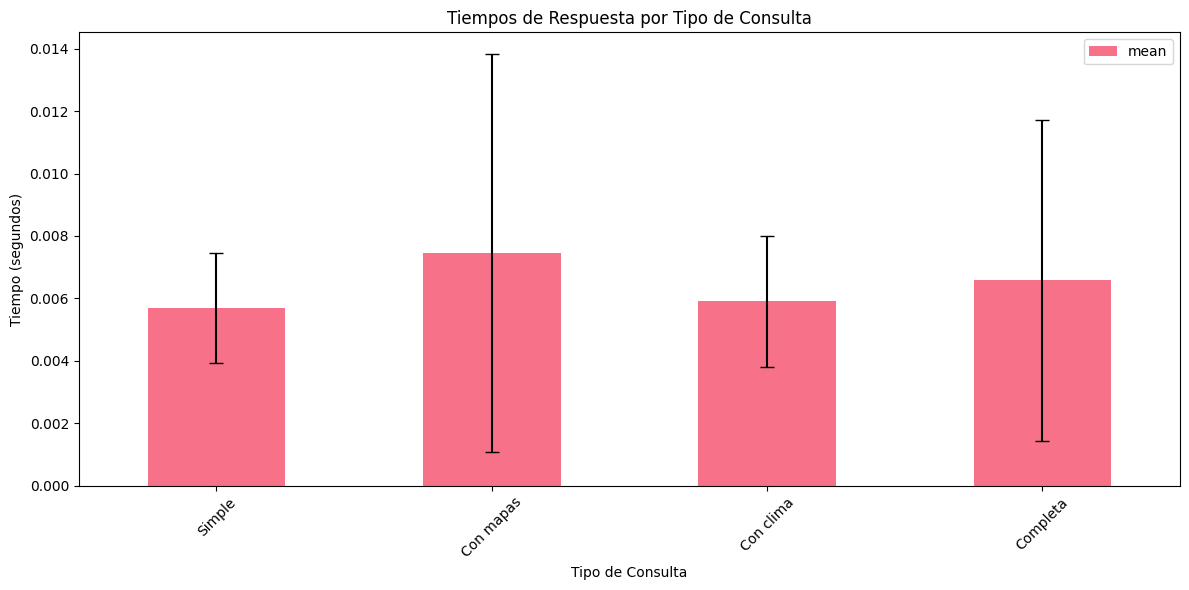

<Figure size 1000x500 with 0 Axes>

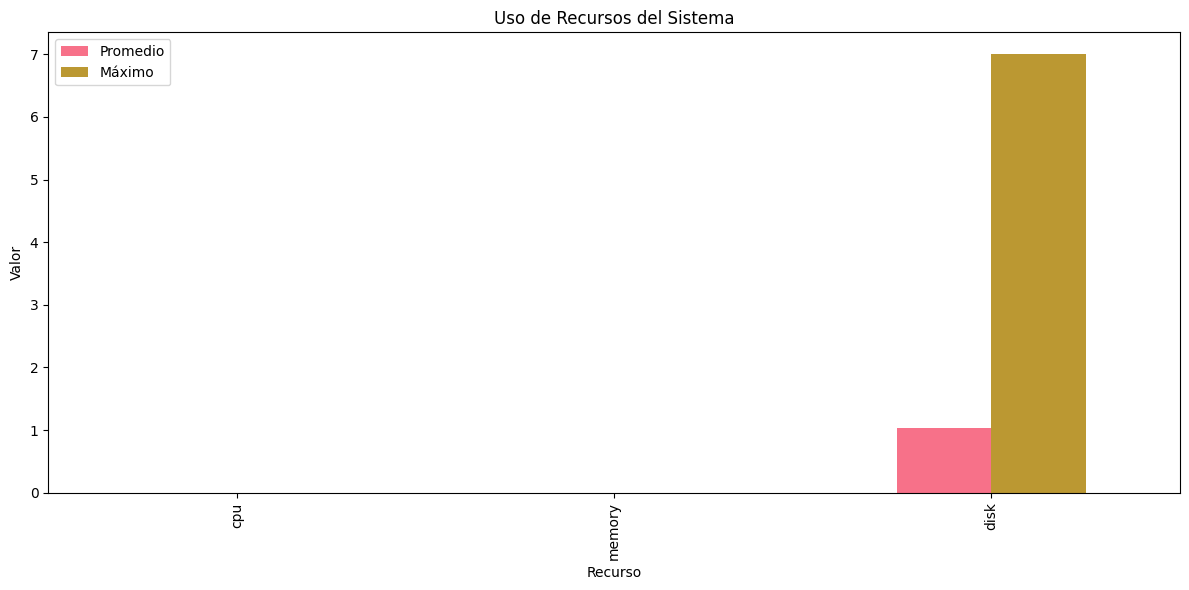


Estadísticas detalladas:

Tiempos de respuesta:
      Simple  Con mapas  Con clima  Completa
mean   0.006      0.007      0.006     0.007
std    0.002      0.006      0.002     0.005
min    0.003      0.003      0.003     0.002
max    0.012      0.044      0.011     0.033

Uso de recursos:
      cpu  memory  disk
mean  0.0     0.0  1.04
max   0.0     0.0  7.00


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de visualización
# plt.style.use('seaborn')
sns.set_palette("husl")

# 1. Gráfico de tiempos de respuesta
plt.figure(figsize=(12, 6))
response_times_df = pd.DataFrame(stats['response_times']).T
ax = response_times_df[['mean', 'std']].plot(kind='bar', yerr='std', capsize=5)
plt.title('Tiempos de Respuesta por Tipo de Consulta')
plt.xlabel('Tipo de Consulta')
plt.ylabel('Tiempo (segundos)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Gráfico de uso de recursos
plt.figure(figsize=(10, 5))
resource_df = pd.DataFrame(stats['resource_usage']).T
resource_df[['mean', 'max']].plot(kind='bar')
plt.title('Uso de Recursos del Sistema')
plt.xlabel('Recurso')
plt.ylabel('Valor')
plt.legend(['Promedio', 'Máximo'])
plt.tight_layout()
plt.show()

# Imprimir estadísticas detalladas
print("\nEstadísticas detalladas:")
print("\nTiempos de respuesta:")
print(pd.DataFrame(stats['response_times']).round(3))

print("\nUso de recursos:")
print(pd.DataFrame(stats['resource_usage']).round(3))

## Pruebas de Precisión Semántica y Geocodificación

A continuación se realizan pruebas específicas para evaluar:
1. Precisión de búsqueda semántica para diferentes tipos de consultas
2. Efectividad de la geocodificación para diferentes tipos de ubicaciones

### Pruebas Semánticas

INFO:semantic_search_evaluation:Iniciando evaluación de búsqueda semántica...
INFO:semantic_search_evaluation:Configurando coordinador para pruebas...
INFO:app.agents.CoordinatorAgent:CoordinatorAgent initialized
INFO:semantic_search_evaluation:Configurando agentes para pruebas...
INFO:app.agents.KnowledgeAgent:KnowledgeAgent initialized
INFO:app.data_managers.crawler:CrawlerManager inicializado. Directorio de datos: e:\Work\Kmy\sim-ia-sri\base\app\data_managers\..\..\data\raw
INFO:app.data_managers.crawler:Inicializando crawler habana_cultural_museos para http://habanacultural.ohc.cu


INFO:app.data_managers.crawler:Crawler habana_cultural_museos registrado exitosamente
INFO:app.agents.WeatherAgent:WeatherAgent initialized
INFO:app.agents.LocationAgent:LocationAgent initialized
INFO:app.agents.LLMAgent:LLMAgent initialized
INFO:app.agents.UIAgent:UIAgent initialized
INFO:app.agents.PlannerAgent:PlannerAgent initialized
INFO:app.agents.UserAgent:UserAgent initialized
INFO:app.agents.CoordinatorAgent:Registered agent: KNOWLEDGE
INFO:app.agents.CoordinatorAgent:Registered agent: WEATHER
INFO:app.agents.CoordinatorAgent:Registered agent: LOCATION
INFO:app.agents.CoordinatorAgent:Registered agent: LLM
INFO:app.agents.CoordinatorAgent:Registered agent: UI
INFO:app.agents.CoordinatorAgent:Registered agent: PLANNER
INFO:app.agents.CoordinatorAgent:Registered agent: USER
INFO:app.agents.CoordinatorAgent:Initialized agent: USER
INFO:app.agents.CoordinatorAgent:Initialized agent: KNOWLEDGE
INFO:app.agents.CoordinatorAgent:Initialized agent: PLANNER
INFO:app.agents.CoordinatorAg


RESULTADOS DETALLADOS DE BÚSQUEDA SEMÁNTICA

RESUMEN GENERAL:
  - Total de consultas evaluadas: 15
  - Precisión promedio: 0.019
  - Recall promedio: 0.800
  - F1-Score promedio: 0.037
  - Confianza promedio: 0.900
  - Tasa de éxito en respuestas: 1.000

RESULTADOS POR TIPO:

  DIRECTAS:
    - Consultas: 5
    - Precisión: 0.025 ± 0.006
    - Recall: 1.000 ± 0.000
    - F1-Score: 0.048 ± 0.011
    - Confianza: 0.900 ± 0.000

  SINONIMOS:
    - Consultas: 5
    - Precisión: 0.016 ± 0.009
    - Recall: 0.667 ± 0.333
    - F1-Score: 0.032 ± 0.017
    - Confianza: 0.900 ± 0.000

  INDIRECTAS:
    - Consultas: 5
    - Precisión: 0.017 ± 0.007
    - Recall: 0.733 ± 0.279
    - F1-Score: 0.033 ± 0.014
    - Confianza: 0.900 ± 0.000

CASOS PROBLEMÁTICOS (F1 < 0.3):
  - 'Museo de la Revolución en La Habana' (F1: 0.052)
    Error: Sin error
  - 'Playas de Varadero' (F1: 0.028)
    Error: Sin error
  - 'Hotel Nacional de Cuba' (F1: 0.048)
    Error: Sin error
  - 'Castillo del Morro Santiago' (F

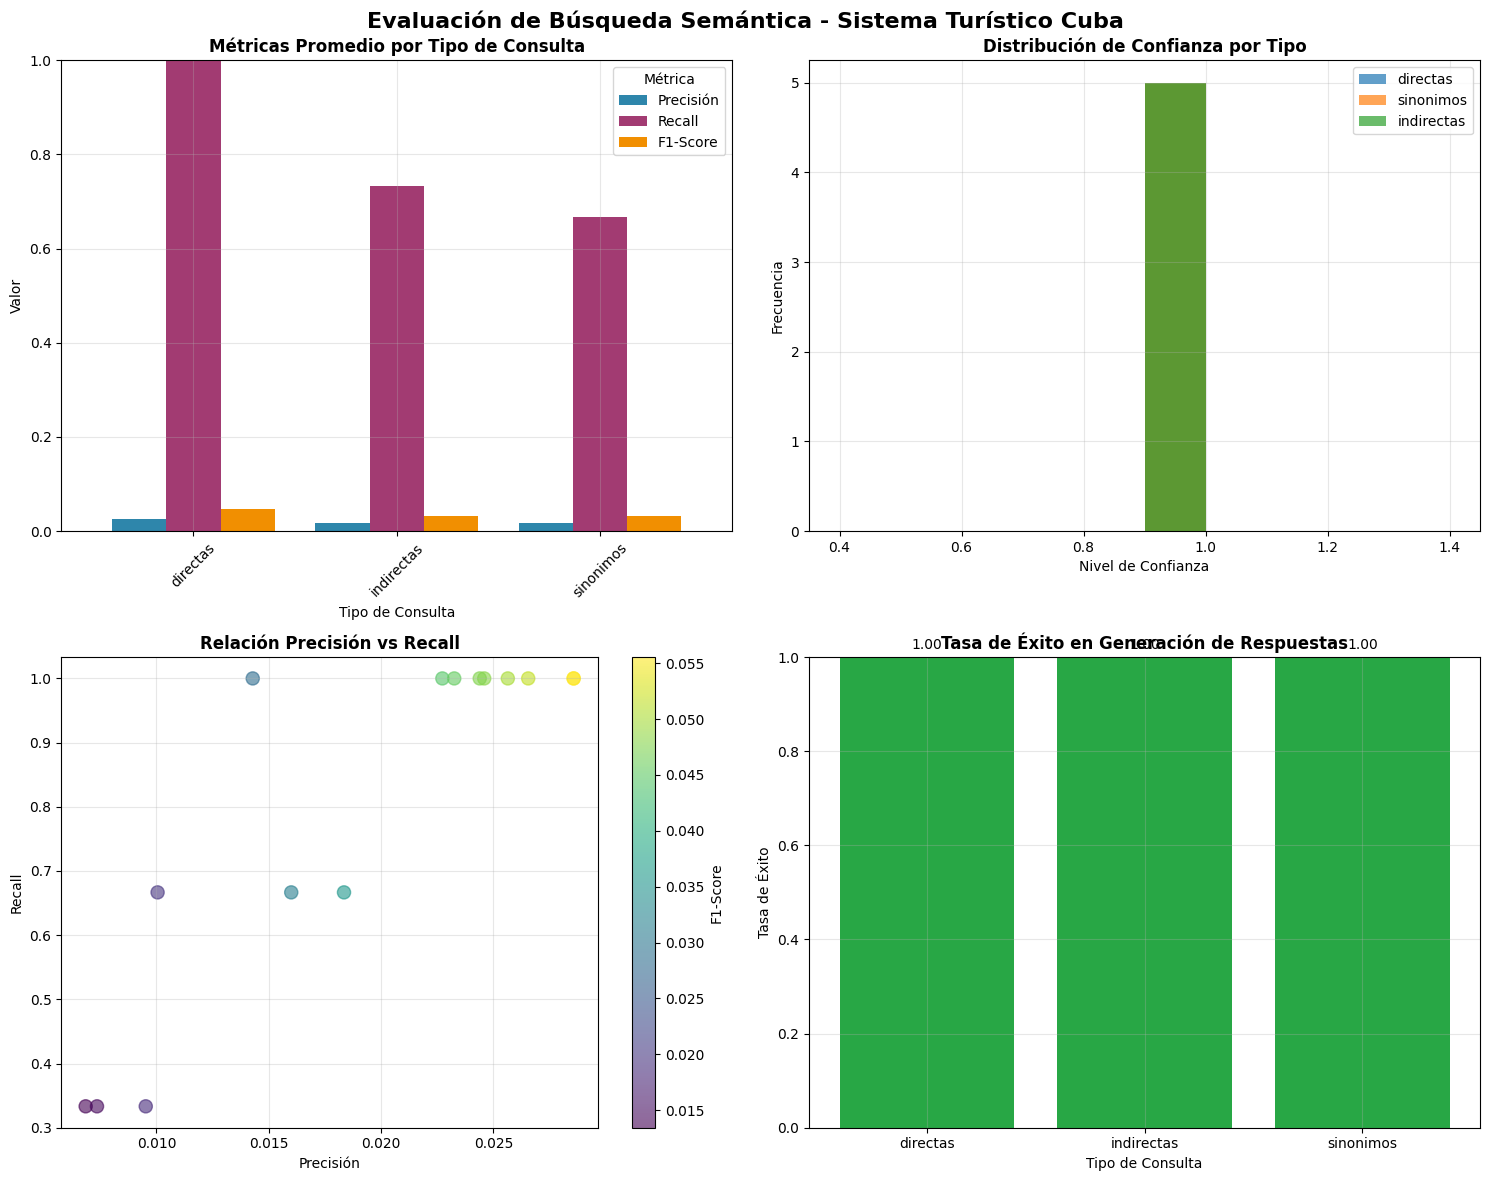

INFO:semantic_search_evaluation:Resultados guardados en: semantic_search_evaluation_20250618_153944.csv


In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import asyncio
import os
from typing import List, Dict, Any, Set
import logging

# Importar los agentes y clases necesarias del sistema
from app.agents.coordinator_agent import CoordinatorAgent
from app.agents.knowledge_agent import KnowledgeAgent
from app.agents.weather_agent import WeatherAgent
from app.agents.location_agent import LocationAgent
from app.agents.llm_agent import LLMAgent
from app.agents.ui_agent import UIAgent
from app.agents.user_agent import UserAgent
from app.agents.planner_agent import PlannerAgent
from app.agents.interfaces import AgentContext, AgentType

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("semantic_search_evaluation")

def create_test_context(query: str, user_id: str = "test_user") -> AgentContext:
    """
    Crea un contexto de prueba para evaluar el sistema.
    
    Args:
        query: Consulta de prueba
        user_id: ID del usuario de prueba
        
    Returns:
        AgentContext configurado para la prueba
    """
    context = AgentContext(query=query)
    context.metadata["user_id"] = user_id
    return context

async def setup_test_coordinator(data_dir: str = "test_data") -> CoordinatorAgent:
    """
    Configura el coordinador para las pruebas.
    
    Args:
        data_dir: Directorio de datos de prueba
        
    Returns:
        CoordinatorAgent configurado
    """
    try:
        # Crear directorio de datos de prueba si no existe
        os.makedirs(data_dir, exist_ok=True)
        
        # Inicializar coordinador
        coordinator = CoordinatorAgent(data_dir)
        
        # Crear e registrar agentes
        logger.info("Configurando agentes para pruebas...")
        
        knowledge_agent = KnowledgeAgent(data_dir)
        weather_agent = WeatherAgent()
        location_agent = LocationAgent()
        llm_agent = LLMAgent()
        ui_agent = UIAgent()
        planner_agent = PlannerAgent()
        user_agent = UserAgent(data_dir)
        
        # Registrar agentes
        coordinator.register_agent(knowledge_agent)
        coordinator.register_agent(weather_agent)
        coordinator.register_agent(location_agent)
        coordinator.register_agent(llm_agent)
        coordinator.register_agent(ui_agent)
        coordinator.register_agent(planner_agent)
        coordinator.register_agent(user_agent)
        
        # Inicializar sistema
        await coordinator.initialize()
        
        logger.info("Coordinador configurado exitosamente")
        return coordinator
        
    except Exception as e:
        logger.error(f"Error configurando coordinador: {str(e)}")
        raise

def extract_terms_from_context(context: AgentContext) -> Set[str]:
    """
    Extrae términos relevantes del contexto procesado.
    
    Args:
        context: Contexto procesado por el sistema
        
    Returns:
        Set de términos encontrados
    """
    found_terms = set()
    
    try:
        # Extraer términos de la respuesta principal
        if context.response:
            found_terms.update(re.findall(r'\w+', context.response.lower()))
        
        # Extraer términos de la información de conocimiento
        knowledge_items = context.metadata.get("knowledge", [])
        for item in knowledge_items:
            if isinstance(item, dict):
                # Extraer del título/nombre
                if "name" in item:
                    found_terms.update(re.findall(r'\w+', str(item["name"]).lower()))
                
                # Extraer de la descripción
                if "description" in item:
                    found_terms.update(re.findall(r'\w+', str(item["description"]).lower()))
                
                # Extraer de datos anidados
                data = item.get("data", {})
                if isinstance(data, dict):
                    for field in ["name", "description", "type"]:
                        if field in data:
                            found_terms.update(re.findall(r'\w+', str(data[field]).lower()))
        
        # Extraer términos de ubicaciones
        for location in context.locations:
            if "name" in location:
                found_terms.update(re.findall(r'\w+', str(location["name"]).lower()))
            if "description" in location:
                found_terms.update(re.findall(r'\w+', str(location["description"]).lower()))
        
        # Extraer términos de fuentes
        for source in context.sources:
            found_terms.update(re.findall(r'\w+', str(source).lower()))
        
        # Filtrar términos muy cortos o comunes
        filtered_terms = {
            term for term in found_terms 
            if len(term) > 2 and term not in {
                'the', 'and', 'for', 'with', 'que', 'del', 'los', 'las', 'una', 'uno'
            }
        }
        
        return filtered_terms
        
    except Exception as e:
        logger.error(f"Error extrayendo términos: {str(e)}")
        return set()

async def evaluate_semantic_search(coordinator: CoordinatorAgent = None) -> pd.DataFrame:
    """
    Evalúa la precisión de búsqueda semántica usando el sistema real.
    
    Args:
        coordinator: Coordinador del sistema (opcional, se crea uno si no se proporciona)
        
    Returns:
        DataFrame con las métricas de evaluación
    """
    # Casos de prueba organizados por tipo
    test_cases = {
        'directas': [
            ("Museo de la Revolución en La Habana", ["museo", "revolución", "habana"]),
            ("Playas de Varadero", ["playa", "varadero"]),
            ("Hotel Nacional de Cuba", ["hotel", "nacional", "cuba"]),
            ("Castillo del Morro Santiago", ["castillo", "morro", "santiago"]),
            ("Teatro García Lorca", ["teatro", "garcía", "lorca"])
        ],
        'sinonimos': [
            ("sitios históricos cerca del malecón", ["histórico", "malecón", "sitio"]),
            ("lugares para observar el atardecer", ["lugar", "atardecer", "observar"]),
            ("zonas con buena gastronomía", ["gastronomía", "zona", "comida"]),
            ("centros culturales en La Habana", ["cultural", "centro", "habana"]),
            ("espacios para el arte cubano", ["arte", "cubano", "espacio"])
        ],
        'indirectas': [
            ("lugares con ambiente colonial español", ["colonial", "español", "arquitectura"]),
            ("sitios para explorar la cultura afrocubana", ["afrocubano", "cultura", "tradición"]),
            ("donde puedo aprender sobre la historia local", ["historia", "local", "aprender"]),
            ("experiencias auténticas de la vida cubana", ["auténtico", "cubano", "vida"]),
            ("lugares que muestran la herencia cultural", ["herencia", "cultural", "mostrar"])
        ]
    }

    # Configurar coordinador si no se proporciona
    if coordinator is None:
        logger.info("Configurando coordinador para pruebas...")
        coordinator = await setup_test_coordinator()

    results = []
    
    for tipo, casos in test_cases.items():
        logger.info(f"Evaluando casos de tipo: {tipo}")
        
        for i, (consulta, expected_terms) in enumerate(casos):
            try:
                logger.info(f"Procesando consulta {i+1}/{len(casos)}: {consulta}")
                
                # Crear contexto de prueba
                context = create_test_context(consulta, f"test_user_{tipo}_{i}")
                
                # Procesar consulta con el coordinador
                response_context = await coordinator.process(context)
                
                # Extraer términos de los resultados del sistema
                found_terms = extract_terms_from_context(response_context)
                
                # Normalizar términos esperados
                expected_terms_set = {term.lower() for term in expected_terms}
                
                # Calcular métricas
                tp = len(found_terms & expected_terms_set)  # True Positives
                fp = len(found_terms - expected_terms_set)  # False Positives  
                fn = len(expected_terms_set - found_terms)  # False Negatives
                
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                
                # Información adicional del contexto
                knowledge_count = len(response_context.metadata.get("knowledge", []))
                location_count = len(response_context.locations)
                confidence = response_context.confidence
                
                results.append({
                    "tipo": tipo,
                    "consulta": consulta,
                    "esperados": ", ".join(sorted(expected_terms_set)),
                    "obtenidos": ", ".join(sorted(found_terms)) if found_terms else "Sin resultados",
                    "precision": precision,
                    "recall": recall,
                    "f1": f1,
                    "confianza": confidence,
                    "items_conocimiento": knowledge_count,
                    "ubicaciones": location_count,
                    "terminos_coincidentes": tp,
                    "terminos_total_encontrados": len(found_terms),
                    "respuesta_generada": bool(response_context.response),
                    "error": response_context.error or "Sin error"
                })
                
                logger.info(f"  -> Precisión: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
                
            except Exception as e:
                error_msg = f"ERROR: {str(e)}"
                logger.error(f"Error procesando consulta '{consulta}': {error_msg}")
                
                results.append({
                    "tipo": tipo,
                    "consulta": consulta,
                    "esperados": ", ".join(expected_terms),
                    "obtenidos": error_msg,
                    "precision": 0,
                    "recall": 0,
                    "f1": 0,
                    "confianza": 0,
                    "items_conocimiento": 0,
                    "ubicaciones": 0,
                    "terminos_coincidentes": 0,
                    "terminos_total_encontrados": 0,
                    "respuesta_generada": False,
                    "error": error_msg
                })

    return pd.DataFrame(results)

def visualize_results(df: pd.DataFrame) -> None:
    """
    Crea visualizaciones de los resultados de evaluación.
    
    Args:
        df: DataFrame con los resultados
    """
    try:
        # Configurar estilo de matplotlib
        plt.style.use('default')
        
        # Crear figura con subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Evaluación de Búsqueda Semántica - Sistema Turístico Cuba', fontsize=16, fontweight='bold')
        
        # 1. Métricas por tipo de consulta
        ax1 = axes[0, 0]
        df_group = df.groupby("tipo")[["precision", "recall", "f1"]].mean()
        df_group.plot(kind='bar', ax=ax1, width=0.8, color=['#2E86AB', '#A23B72', '#F18F01'])
        ax1.set_title('Métricas Promedio por Tipo de Consulta', fontweight='bold')
        ax1.set_xlabel('Tipo de Consulta')
        ax1.set_ylabel('Valor')
        ax1.legend(title='Métrica', labels=['Precisión', 'Recall', 'F1-Score'])
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
        ax1.set_ylim(0, 1)
        ax1.grid(True, alpha=0.3)
        
        # 2. Distribución de confianza por tipo
        ax2 = axes[0, 1]
        for tipo in df['tipo'].unique():
            subset = df[df['tipo'] == tipo]
            ax2.hist(subset['confianza'], alpha=0.7, label=tipo, bins=10)
        ax2.set_title('Distribución de Confianza por Tipo', fontweight='bold')
        ax2.set_xlabel('Nivel de Confianza')
        ax2.set_ylabel('Frecuencia')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Correlación entre métricas
        ax3 = axes[1, 0]
        scatter = ax3.scatter(df['precision'], df['recall'], 
                            c=df['f1'], s=df['confianza']*100, 
                            alpha=0.6, cmap='viridis')
        ax3.set_title('Relación Precisión vs Recall', fontweight='bold')
        ax3.set_xlabel('Precisión')
        ax3.set_ylabel('Recall')
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax3, label='F1-Score')
        
        # 4. Éxito de generación de respuestas
        ax4 = axes[1, 1]
        success_rate = df.groupby('tipo')['respuesta_generada'].mean()
        colors = ['#28a745' if x > 0.8 else '#ffc107' if x > 0.5 else '#dc3545' for x in success_rate]
        bars = ax4.bar(success_rate.index, success_rate.values, color=colors)
        ax4.set_title('Tasa de Éxito en Generación de Respuestas', fontweight='bold')
        ax4.set_xlabel('Tipo de Consulta')
        ax4.set_ylabel('Tasa de Éxito')
        ax4.set_ylim(0, 1)
        ax4.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for bar in bars:

            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        logger.error(f"Error en visualización: {str(e)}")
        print("Error generando visualizaciones. Mostrando datos en texto:")
        print(df.groupby("tipo")[["precision", "recall", "f1"]].mean().round(3))

def print_detailed_results(df: pd.DataFrame) -> None:
    """
    Imprime resultados detallados en formato legible.
    
    Args:
        df: DataFrame con los resultados
    """
    print("\n" + "="*80)
    print("RESULTADOS DETALLADOS DE BÚSQUEDA SEMÁNTICA")
    print("="*80)
    
    # Resumen general
    print(f"\nRESUMEN GENERAL:")
    print(f"  - Total de consultas evaluadas: {len(df)}")
    print(f"  - Precisión promedio: {df['precision'].mean():.3f}")
    print(f"  - Recall promedio: {df['recall'].mean():.3f}")
    print(f"  - F1-Score promedio: {df['f1'].mean():.3f}")
    print(f"  - Confianza promedio: {df['confianza'].mean():.3f}")
    print(f"  - Tasa de éxito en respuestas: {df['respuesta_generada'].mean():.3f}")
    
    # Resultados por tipo
    print(f"\nRESULTADOS POR TIPO:")
    for tipo in df['tipo'].unique():
        subset = df[df['tipo'] == tipo]
        print(f"\n  {tipo.upper()}:")
        print(f"    - Consultas: {len(subset)}")
        print(f"    - Precisión: {subset['precision'].mean():.3f} ± {subset['precision'].std():.3f}")
        print(f"    - Recall: {subset['recall'].mean():.3f} ± {subset['recall'].std():.3f}")
        print(f"    - F1-Score: {subset['f1'].mean():.3f} ± {subset['f1'].std():.3f}")
        print(f"    - Confianza: {subset['confianza'].mean():.3f} ± {subset['confianza'].std():.3f}")
    
    # Casos problemáticos
    problematic = df[df['f1'] < 0.3]
    if len(problematic) > 0:
        print(f"\nCASOS PROBLEMÁTICOS (F1 < 0.3):")
        for _, row in problematic.iterrows():
            print(f"  - '{row['consulta']}' (F1: {row['f1']:.3f})")
            print(f"    Error: {row['error']}")
    
    # Mejores casos
    best_cases = df[df['f1'] > 0.7]
    if len(best_cases) > 0:
        print(f"\nMEJORES CASOS (F1 > 0.7):")
        for _, row in best_cases.iterrows():
            print(f"  - '{row['consulta']}' (F1: {row['f1']:.3f})")

async def run_evaluation():
    """
    Ejecuta la evaluación completa del sistema.
    """
    try:
        logger.info("Iniciando evaluación de búsqueda semántica...")
        
        # Ejecutar evaluación
        df_results = await evaluate_semantic_search()
        
        # Mostrar resultados
        print_detailed_results(df_results)
        
        # Crear visualizaciones
        visualize_results(df_results)
        
        # Guardar resultados
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        filename = f"semantic_search_evaluation_{timestamp}.csv"
        df_results.to_csv(filename, index=False)
        logger.info(f"Resultados guardados en: {filename}")
        
        # Retornar métricas agrupadas para uso posterior
        return df_results.groupby("tipo")[["precision", "recall", "f1"]].mean()
        
    except Exception as e:
        logger.error(f"Error en evaluación: {str(e)}")
        raise


results = await run_evaluation()

### Pruebas de Geocodificación

INFO:app.agents.CoordinatorAgent:CoordinatorAgent initialized
INFO:app.agents.KnowledgeAgent:KnowledgeAgent initialized
INFO:app.data_managers.crawler:CrawlerManager inicializado. Directorio de datos: e:\Work\Kmy\sim-ia-sri\base\app\data_managers\..\..\data\raw
INFO:app.data_managers.crawler:Inicializando crawler habana_cultural_museos para http://habanacultural.ohc.cu
INFO:app.data_managers.crawler:Crawler habana_cultural_museos registrado exitosamente
INFO:app.agents.WeatherAgent:WeatherAgent initialized
INFO:app.agents.LocationAgent:LocationAgent initialized
INFO:app.agents.LLMAgent:LLMAgent initialized
INFO:app.agents.UIAgent:UIAgent initialized
INFO:app.agents.PlannerAgent:PlannerAgent initialized
INFO:app.agents.UserAgent:UserAgent initialized
INFO:app.agents.CoordinatorAgent:Registered agent: KNOWLEDGE
INFO:app.agents.CoordinatorAgent:Registered agent: WEATHER
INFO:app.agents.CoordinatorAgent:Registered agent: LOCATION
INFO:app.agents.CoordinatorAgent:Registered agent: LLM
INFO:


Ejecutando pruebas de geocodificación...


INFO:httpx:HTTP Request: POST https://api.fireworks.ai/inference/v1/chat/completions "HTTP/1.1 200 OK"
INFO:app.agents.LocationAgent:LLM extraction found 1 locations
INFO:app.agents.LocationAgent:Geocoded: La Habana -> {'lat': 23.1136, 'lon': -82.3666}
INFO:app.agents.LocationAgent:Found 1 geocoded locations
INFO:app.agents.LocationAgent:Extracting locations from: Santiago de Cuba...
INFO:httpx:HTTP Request: POST https://api.fireworks.ai/inference/v1/chat/completions "HTTP/1.1 200 OK"
INFO:app.agents.LocationAgent:LLM extraction found 1 locations
INFO:app.agents.LocationAgent:Geocoded: Santiago de Cuba -> {'lat': 20.0217, 'lon': -75.8283}
INFO:app.agents.LocationAgent:Found 1 geocoded locations
INFO:app.agents.LocationAgent:Extracting locations from: Varadero...
INFO:httpx:HTTP Request: POST https://api.fireworks.ai/inference/v1/chat/completions "HTTP/1.1 200 OK"
INFO:app.agents.LocationAgent:Falling back to pattern-based extraction
INFO:app.agents.LocationAgent:Pattern extraction foun

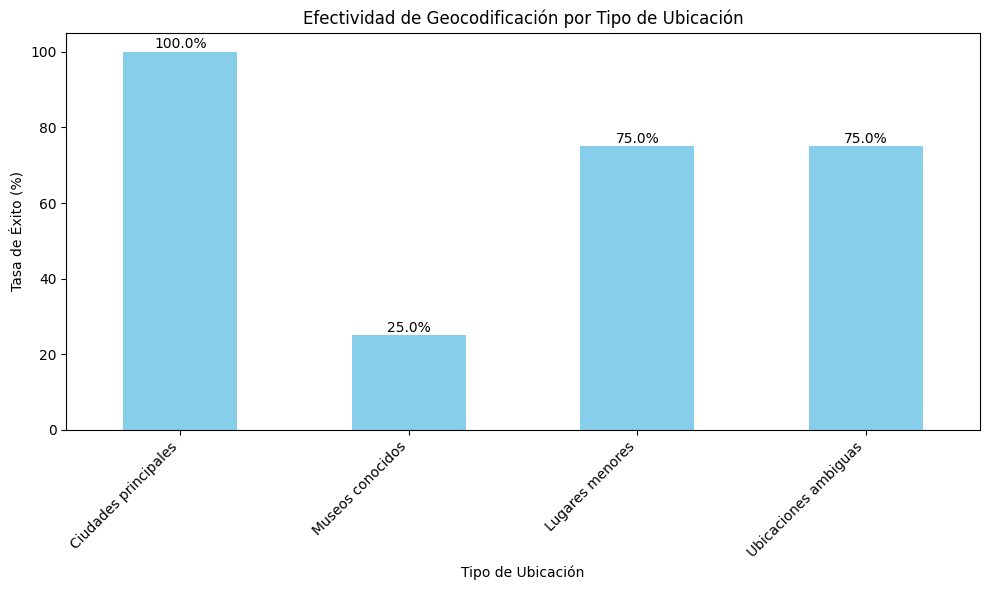


Resultados detallados de geocodificación:
      Tipo de ubicación  Tasa de éxito (%)
0  Ciudades principales              100.0
1      Museos conocidos               25.0
2       Lugares menores               75.0
3  Ubicaciones ambiguas               75.0
Tasa de éxito de geocodificación promedio: 68.75%


In [4]:
from app.agents.coordinator_agent import CoordinatorAgent
from app.agents.knowledge_agent import KnowledgeAgent
from app.agents.llm_agent import LLMAgent
from app.agents.planner_agent import PlannerAgent
from app.agents.ui_agent import UIAgent
from app.agents.user_agent import UserAgent
from app.agents.weather_agent import WeatherAgent
from app.agents.location_agent import LocationAgent
from app.agents.location_agent import LocationAgent
from app.agents.interfaces import AgentContext


async def evaluate_geocoding():
    """
    Evalúa la efectividad de la geocodificación usando el LocationAgent real.
    """

    location_test_cases = {
        'Ciudades principales': [
            "La Habana",
            "Santiago de Cuba",
            "Varadero",
            "Trinidad"
        ],
        'Museos conocidos': [
            "Museo de la Revolución",
            "Museo Nacional de Bellas Artes",
            "Museo del Ron",
            "Casa Natal de José Martí"
        ],
        'Lugares menores': [
            "Playa Ancón",
            "Valle de Viñales",
            "Cayo Guillermo",
            "Morro de Santiago"
        ],
        'Ubicaciones ambiguas': [
            "Plaza Central",
            "Malecón",
            "Parque histórico",
            "Centro colonial"
        ]
    }

    data_dir = "/data"
    coordinator = CoordinatorAgent(data_dir)
    
    # Registrar agentes
    knowledge_agent = KnowledgeAgent(data_dir)
    weather_agent = WeatherAgent()
    location_agent = LocationAgent()
    llm_agent = LLMAgent()
    ui_agent = UIAgent()
    planner_agent = PlannerAgent()
    user_agent = UserAgent(data_dir)
    
    coordinator.register_agent(knowledge_agent)
    coordinator.register_agent(weather_agent)
    coordinator.register_agent(location_agent)
    coordinator.register_agent(llm_agent)
    coordinator.register_agent(ui_agent)
    coordinator.register_agent(planner_agent)
    coordinator.register_agent(user_agent)

    agent = LocationAgent()
    await agent.initialize()
    agent.set_coordinator(coordinator)

    results = []
    for tipo, lugares in location_test_cases.items():
        success = 0
        for lugar in lugares:
            context = AgentContext(query=lugar)
            context = await agent.process(context)
            if hasattr(context, "locations") and context.locations:
                success += 1
        tasa = 100 * success / len(lugares)
        results.append({"Tipo de ubicación": tipo, "Tasa de éxito (%)": tasa})

    df = pd.DataFrame(results)
    # Visualización
    plt.figure(figsize=(10, 6))
    ax = df.set_index("Tipo de ubicación")["Tasa de éxito (%)"].plot(kind='bar', color='skyblue')
    plt.title('Efectividad de Geocodificación por Tipo de Ubicación')
    plt.xlabel('Tipo de Ubicación')
    plt.ylabel('Tasa de Éxito (%)')
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(df["Tasa de éxito (%)"]):
        ax.text(i, v + 1, f'{v:.1f}%', ha='center')
    plt.ylim(0, 105)
    plt.tight_layout()
    plt.show()
    print("\nResultados detallados de geocodificación:")
    print(df)
    return df

print("\nEjecutando pruebas de geocodificación...")

geocoding_df = await evaluate_geocoding()
avg_geocoding = geocoding_df['Tasa de éxito (%)'].mean()

print(f"Tasa de éxito de geocodificación promedio: {avg_geocoding:.2f}%")